Utiliza esta base de datos https://www.kaggle.com/uciml/irisLinks to an external site. para clasificar los diferentes tipos de Iris en base a 2 características, las medidas del sépaloLinks to an external site. y las medidas de los pétalosLinks to an external site., ambos por su ancho y largo.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [ ]:
# Crear dataframe
df = pd.read_csv("Iris.csv")
df = df.loc[:,df.columns != 'Id']   # quitamos ID

X = df.loc[:,df.columns != 'Species']
y = df['Species']

# Arbol de Decision

In [ ]:
# Rangos de valores para cada clasificacion
setosa_df = df.loc[df['Species'] == 'Iris-setosa']
versicolor_df = df.loc[df['Species'] == 'Iris-versicolor']
virginica_df = df.loc[df['Species'] == 'Iris-virginica']

cols = ["Species", "SepalLengthCm","SepalWidthCm","PetalLengthCm","PetalWidthCm"]
range_df = pd.DataFrame(columns=cols)

range_df.loc[len(range_df.index)] = ['Iris-setosa'] + [f'({setosa_df[col].min()}, {setosa_df[col].max()})' for col in cols[1:]]
range_df.loc[len(range_df.index)] = ['Iris-versicolor'] + [f'({versicolor_df[col].min()}, {versicolor_df[col].max()})' for col in cols[1:]]
range_df.loc[len(range_df.index)] = ['Iris-virginica'] + [f'({virginica_df[col].min()}, {virginica_df[col].max()})' for col in cols[1:]]

range_df

Viendo los rangos de los valores separados por tipo de Iris, vemos que el largo y ancho de pétalo son una hojas puras. Si el largo de pétalo es menor a 1.9 o el ancho del pétalo es menor a 0.6, sabemos que es Setosa. Para las otras especies debemos analizar la ganancia de información.

Luego usamos el DecisionTreeClassifier de SKLearn

In [ ]:
irisTree = DecisionTreeClassifier(criterion="entropy", max_depth=5)
irisTree.fit(X, y)

In [ ]:
# Visualizacion

from six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 
dot_data = StringIO()
filename = "irisTree.png"
featureNames = df.columns[:-1]
print(featureNames)
targetNames = df["Species"].unique().tolist()
out=tree.export_graphviz(irisTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

Ya visualizado vemos que llegó a la misma conclusión de que PetalWidth y PetalLength llevan a Hojas puras y lo hace primero, luego va separando virginica y versicolor

# Clasificador Bayesiano

In [31]:
from math import sqrt
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Split by classes
df_classes = {}
for species in targetNames:
    new_df = df[df['Species'] == species].loc[:,df.columns != 'Species']
    df_classes[species] = new_df
    
# media de iterable
def mean(numbers):
 return sum(numbers)/float(len(numbers))
 
# Calculate the desv estandar de iterable
def stdev(numbers):
 avg = mean(numbers)
 variance = sum([(x-avg)**2 for x in numbers]) / float(len(numbers)-1)
 return sqrt(variance)
 
# Calcula atributos estadisticos de df
def summarize_dataset(dataset):
    summaries = []
    for column in dataset:
        print(column)
        summaries.append((mean(dataset[column]), stdev(dataset[column]), len(dataset[column])))
    return summaries

print(df_classes.items())

# Atributos por columna, por clase
summaries = dict()
for class_value, rows in df_classes.items():
    summaries[class_value] = summarize_dataset(rows)

summaries

dict_items([('Iris-setosa',     SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
0             5.1           3.5            1.4           0.2
1             4.9           3.0            1.4           0.2
2             4.7           3.2            1.3           0.2
3             4.6           3.1            1.5           0.2
4             5.0           3.6            1.4           0.2
5             5.4           3.9            1.7           0.4
6             4.6           3.4            1.4           0.3
7             5.0           3.4            1.5           0.2
8             4.4           2.9            1.4           0.2
9             4.9           3.1            1.5           0.1
10            5.4           3.7            1.5           0.2
11            4.8           3.4            1.6           0.2
12            4.8           3.0            1.4           0.1
13            4.3           3.0            1.1           0.1
14            5.8           4.0            1.2           

{'Iris-setosa': [(5.005999999999999, 0.3524896872134512, 50),
  (3.4180000000000006, 0.38102439795469095, 50),
  (1.464, 0.1735111594364455, 50),
  (0.2439999999999999, 0.10720950308167837, 50)],
 'Iris-versicolor': [(5.936, 0.5161711470638635, 50),
  (2.7700000000000005, 0.3137983233784114, 50),
  (4.26, 0.46991097723995806, 50),
  (1.3259999999999998, 0.197752680004544, 50)],
 'Iris-virginica': [(6.587999999999998, 0.635879593274432, 50),
  (2.9739999999999998, 0.3224966381726376, 50),
  (5.552, 0.5518946956639835, 50),
  (2.026, 0.27465005563666733, 50)]}

In [66]:
from math import exp, pi

# Calcula la funcion de distribucion de probabilidad para x
def calculate_probability(x, mean, stdev):
    exponent = exp(-((x-mean)**2 / (2 * stdev**2 )))
    return (1 / (sqrt(2 * pi) * stdev)) * exponent

# Calcula la probabilidad de que este en cada clase
def calculate_class_probabilities(summaries, row):
    total_rows = sum([summaries[label][0][2] for label in summaries])
    probabilities = dict()
    for class_value, class_summaries in summaries.items():
        probabilities[class_value] = summaries[class_value][0][2]/float(total_rows)
        for i in range(len(class_summaries)):
            mean, stdev, count = class_summaries[i]
            probabilities[class_value] *= calculate_probability(row[i], mean, stdev)
    return probabilities

# Funcion para predecir sobre las filas de un df
def naive_bayes_predict(data: pd.DataFrame, summaries):
    y_pred = []
    # Vectorizamos datos porque .loc no funcionaria al cambiar indices
    vectorized_data = [data[col].to_numpy() for col in data]
    for f1, f2, f3, f4 in zip(vectorized_data[0],vectorized_data[1],vectorized_data[2],vectorized_data[3]):
        # Diccionario con probabilidades
        probabilities = calculate_class_probabilities(summaries, [f1,f2,f3,f4])
        
        # Tomamos la llave del valor mayor
        prediction = max(probabilities, key=probabilities.get)
        y_pred.append(prediction)
        
    return y_pred

# Evaluamos exactitud del clasificador
accuracy_score(naive_bayes_predict(X_test, summaries), y_test)

0.98

0.96


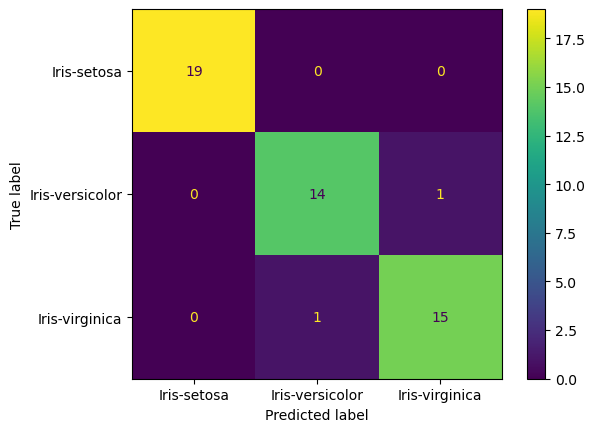

In [68]:
# Comparacion contra Naive Bayes de Scikit
irisBayes = GaussianNB()
irisBayes.fit(X_train, y_train)

y_pred = irisBayes.predict(X_test)
print(accuracy_score(y_pred, y_test))

cm = confusion_matrix(y_test, y_pred, labels=targetNames)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=targetNames)
disp.plot();
